# 모델 평가와 하이퍼파라미터 튜닝의 모범 사례


In [1]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

# UCI 머신 러닝 저장소에서 유방암 데이터셋을 다운로드할 수 없을 때
# 다음 주석을 해제하고 로컬 경로에서 데이터셋을 적재하세요.

# df = pd.read_csv('wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [3]:
le.transform(['M', 'B'])

array([1, 0], dtype=int64)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                    test_size = 0.2,
                    stratify = y,
                    random_state = 1)

참고로 파이썬 3.6부터 지원하는 f-string에 알아보자.
http://zetcode.com/python/fstring/

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(StandardScaler(),
                       PCA(n_components=2),
                       LogisticRegression(solver='liblinear', random_state=1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print(f'테스트 정확도: {pipe_lr.score(X_test, y_test):.3f}')

테스트 정확도: 0.956


## k-겹 교차 검증을 사용한 모델 성능 평가

In [6]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10,
                       random_state=1).split(X_train,
                                            y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f'폴드: {k+1:2d}, 클래스 분포: {np.bincount(y_train[train])}, 정확도: {score:.3f}')

폴드:  1, 클래스 분포: [256 153], 정확도: 0.935
폴드:  2, 클래스 분포: [256 153], 정확도: 0.935
폴드:  3, 클래스 분포: [256 153], 정확도: 0.957
폴드:  4, 클래스 분포: [256 153], 정확도: 0.957
폴드:  5, 클래스 분포: [256 153], 정확도: 0.935
폴드:  6, 클래스 분포: [257 153], 정확도: 0.956
폴드:  7, 클래스 분포: [257 153], 정확도: 0.978
폴드:  8, 클래스 분포: [257 153], 정확도: 0.933
폴드:  9, 클래스 분포: [257 153], 정확도: 0.956
폴드: 10, 클래스 분포: [257 153], 정확도: 0.956


In [7]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=-1)
print(f'CV 정확도 점수: {scores}')
print(f'CV 정확도 점수: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV 정확도 점수: 0.950 +/- 0.014


In [8]:
from sklearn.model_selection import cross_validate

scores = cross_validate(estimator=pipe_lr,
                        X=X_train,
                        y=y_train,
                        scoring=['accuracy'],
                        cv=10,
                        n_jobs=-1,
                        return_train_score=False)

print(f"CV 정확도 점수: {scores['test_accuracy']}")
print(f"CV 정확도 점수: {np.mean(scores['test_accuracy']):.3f} +/- {np.std(scores['test_accuracy']):.3f}")

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV 정확도 점수: 0.950 +/- 0.014


## 학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅 



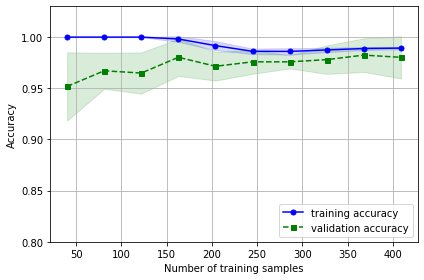

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                       LogisticRegression(solver='liblinear',
                                         penalty='l2',
                                         random_state=1))
train_sizes, train_scores, test_scores = \
                learning_curve(estimator=pipe_lr,
                              X=X_train,
                              y=y_train,
                              train_sizes=np.linspace(
                              0.1, 1, 10),
                              cv=10,
                              n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

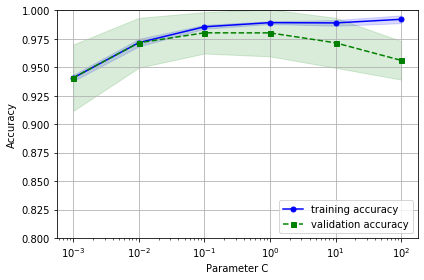

In [10]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1, 10, 100]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr,
                X=X_train,
                y=y_train,
                param_name='logisticregression__C',
                param_range=param_range,
                cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.00])
plt.tight_layout()
plt.show()

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                        SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1,
              1, 10, 100, 1000]
param_grid = [{'svc__C': param_range,
              'svc__kernel': ['linear']},
             {'svc__C': param_range,
             'svc__gamma': param_range,
             'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846153846153847
{'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [12]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f'테스트 정확도: {clf.score(X_test, y_test):.3f}')

테스트 정확도: 0.974


## 여러 가지 성능 평가 지표 



In [13]:
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label=0)
c_gamma_range = [0.01, 0.1, 1, 10]
param_grid = [{'svc__C': c_gamma_range,
              'svc__kernel': ['linear']},
             {'svc__C': c_gamma_range,
             'svc__gamma': c_gamma_range,
             'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring=scorer,
                 cv=10)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9862021456964396
{'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


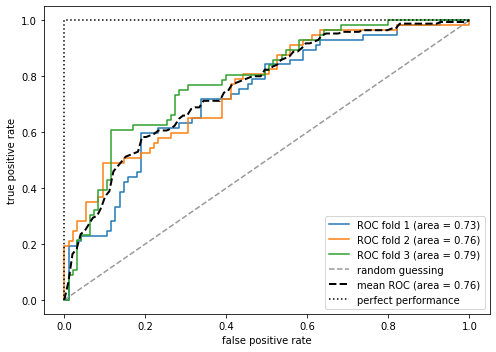

In [14]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(solver='liblinear',
                                           penalty='l2', 
                                           random_state=1, 
                                           C=100.0))

X_train2 = X_train[:, [4, 14]]
    

cv = list(StratifiedKFold(n_splits=3, 
                          random_state=1).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [15]:
np.bincount([0, 2, 0])

array([2, 0, 1], dtype=int64)

In [16]:
import numpy as np

np.bincount([0, 2, 0])

array([2, 0, 1], dtype=int64)

In [17]:
np.bincount([0, 0, 1], weights = [0.2, 0.2, 0.6])

array([0.4, 0.6])

[calibration classifier에 대한 설명](https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#id3)

[calibration classifier 듀토리얼](https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/)

In [19]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator,
                            ClassifierMixin):
    """다수결 투표 앙상블 분류기
    
    매개변수
    --------
    classifiers: 배열 타입, 크기 = [n_classifiers]
        앙상블에 사용할 분류기
        
    vote: str, {'classlabel', 'probability'}
        기본값: 'classlabel'
        'classlabel'이면 예측은 다수인 클래스 레이블의 인덱스가 됩니다
        'probability'면 확률 합이 가장 큰 인덱스로
        클래스 레이블을 예측합니다(보정된 분류기에 추천합니다)
        
    weights: 배열 타입, 크기 = [n_classifiers]
    선택 사항, 기본값: None
    'int' 또는 'float' 값의 리스트가 주어지면 분류기가 이 중요도로 가중치됩니다
    'weights=None'이면 동일하게 취급합니다
    """
    def __init__(self, classifiers,
                vote = 'classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for
                                 key, value in
                                 _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        """분류기를 학습합니다
        
        매개변수
        ---------
        X: {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            훈련 샘플 행렬
            
        y: 배열 타입, 크기 = [n_samples]
            타깃 클래스 레이블 벡터
        
        반환값
        -------
        self: 객체
        
        """
        # self.predict메서드에서 np.argmax를 호출할 때
        # 클래스 레이블이 0부터 시작되어야 하므로 LabelEncoder를 사용합니다
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,
                                       self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """X에 대한 클래스 레이블은 예측합니다
        
        매개변수
        --------
        X: {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            샘플 데이터 행렬
            
        반환값
        --------
        maj_vote: 배열 타입, 크기 = [n_samples]
            예측된 클래스 레이블
        
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X),
                                axis = 1)
        else: # 'classlabel' 투표
            
            # clf.predict 메서드를 사용하여 결과를 모읍니다
            predictions = np.asarray([clf.predict(X)
                                    for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis
        